In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from src.data.prepare_data import prepare_data
from src.data.utils import resample_data
from src.models.model_selection import GridSearch, FeatureSelection
from src.models.classification import Classification
from src.models.evaluation import Evaluation

In [2]:
# read config
with open('config.yml', 'r') as file:
    config=yaml.load(file, Loader= yaml.SafeLoader)
del file

In [3]:
# load and prepare data
df = pd.read_csv(config['data_loader']['path'])
df = prepare_data(df=df)
# display(df.head())
 #display(df['target'].value_counts(normalize=False))

# resample for imbalanced sets
df_sampled = resample_data(df=df, pos_share=0.01)
#df_sampled['target'].value_counts(normalize=False)

In [4]:
# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_sampled.iloc[:,:-1], df_sampled['target']
    , test_size=config['model_selection']['test_set_size']
    , random_state=123
    , shuffle=True
    , stratify=df_sampled['target']
    )

# check the distribution of the target
# print(y_train.value_counts(normalize=False), y_test.value_counts(normalize=False))

In [ ]:
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

# Assume X is the feature matrix and y is the target variable
undersampler = RandomUnderSampler(
    sampling_strategy='majority'
    , random_state=42
    )

X_train_rs, y_train_rs = undersampler.fit_resample(X_train, y_train)

# Check class distributions
print("Original class distribution:", np.bincount(y_train))
print("Resampled class distribution:", np.bincount(y_train_rs))

# split training set into multiple training sets
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(
    X_train_rs, y_train_rs
    , test_size=0.5
    , random_state=123
    , shuffle=True
    , stratify=y_train_rs
    )

X_train_2, X_train_3, y_train_2, y_train_3 = train_test_split(
    X_train_2, y_train_2
    , test_size=0.5
    , random_state=123
    , shuffle=True
    , stratify=y_train_2
    )

print(
    '\n'
    , "\ntrain 1 class distribution:", np.bincount(y_train_1)
    , "\ntrain 2 class distribution:", np.bincount(y_train_2)
    , "\ntrain 3 class distribution:", np.bincount(y_train_3)
    )

Original class distribution: [267397   2701]
Resampled class distribution: [2701 2701]


In [ ]:
# search best algorithm and hyperparams
grid_search = GridSearch(model_selection=config['model_selection'])
grid_search.fit(X=X_train_1, y=y_train_1)

for j in grid_search.results.keys():
    print(j, '-', grid_search.results[j]['best_score'])

c:\Users\gonpr\ML_Projects\Fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\gonpr\ML_Projects\Fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

In [21]:
# greedy feature selection
clf = Classification(
    algorithm=grid_search.best_algorithm
    , **grid_search.best_hyperparams
    )

feature_selection = FeatureSelection(X=X_train_2, y=y_train_2)
feats = feature_selection.wrapper(clf=clf, model_selection=config['model_selection'])
display(feats)

clf.fit(X=pd.concat([X_train_1, X_train_2])[feats], y=pd.concat([y_train_1, y_train_2]))

Index(['V4', 'V14', 'V17'], dtype='object')

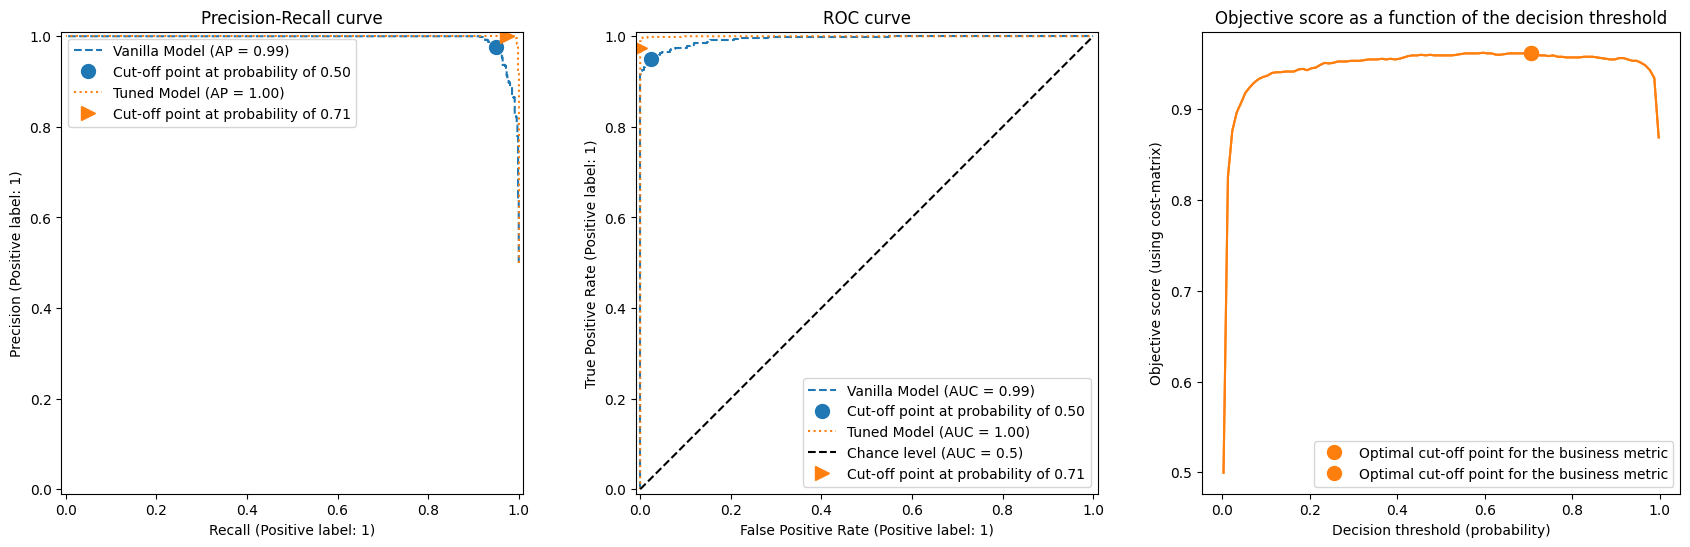

In [25]:
from src.models.model_selection import ClassificationThreshold
from src.visuals.pr_roc_curve import plot_roc_pr_curves

tuned_clf = ClassificationThreshold(model_selection=config['model_selection'])
tuned_clf.fit(clf=clf, X=X_train_3[feats], y=y_train_3)

plot_roc_pr_curves(clf.model, tuned_clf.model, X_train=X_train_3[feats], y_train=y_train_3)

In [27]:
# fit best algorithm on most important features of training data 
clf = Classification(
    algorithm=grid_search.best_algorithm
    , **grid_search.best_hyperparams
    )
clf.fit(
    X=pd.concat([X_train_1, X_train_2, X_train_3])[feats]
    , y=pd.concat([y_train_1, y_train_2, y_train_3])
    )

# predict target value for the test set
y_pred = clf.predict(X_test[feats])
y_score = clf.score(X_test[feats])[:, -1]

In [28]:
eval = Evaluation(clf=clf)
eval.fit(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

ValueError: feature_names mismatch: ['V4', 'V14', 'V17'] ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
training data did not have the following fields: V8, V26, V6, V3, V1, V15, V5, V28, V25, V21, V16, V9, V13, Amount, V22, V7, V20, V18, V11, V19, V24, V10, V2, V12, V27, V23

In [ ]:
from src.visuals.boundary import plot_boundary

plot_boundary(
    X=X_train.iloc[:,[3,6,8]], y=y_train, clf=clf, azim=50, plot_points=True
)

In [ ]:
#pd.DataFrame({'score': y_score, 'label': y_pred}).groupby(by=['label']).describe()
#print(clf.model.decision_path(X_test[best_features[:2]].iloc[:10,:]))

In [ ]:
"""
https://medium.com/towards-data-science/tune-in-decision-threshold-optimization-with-scikit-learns-tunedthresholdclassifiercv-7de558a2cf58
https://scikit-learn.org/stable/auto_examples/model_selection/plot_cost_sensitive_learning.html#tunedthresholdclassifiercv-no-cv
https://scikit-learn.org/stable/modules/classification_threshold.html

overfitting

https://scikit-learn.org/stable/modules/learning_curve.html

feat select
# should feature selection be done before or after model selection?
# should it be trained on different dataset?
"""